<a href="https://colab.research.google.com/github/samkellerhals/food-classification-network/blob/master/models/FoodNet_Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Ensure that kaggle API is installed, create API key, download dataset and unzip
!pip install kaggle
!kaggle datasets download -d sakell/foodclassdata
!echo '{"username":"sakell","key":"121bd0932d4fab1172b2220d6cf787a6"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d sakell/foodclassdata
!unzip -qq foodclassdata.zip

In [0]:
# Import libraries
import numpy as np
from random import randint, uniform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import csv
import os
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision

In [0]:
# Define data directories
train_dir = 'training_data/train_set_struc'
valid_dir = 'valid_data/valid_set_struc'

In [0]:
# PARAMETERS #

# load pretrained model
model = models.vgg16(pretrained=True)

# predefined parameter ranges
zero_to_one = [0,1]
zero_five = [0,0.5]

### Network image input size
IMAGE_INPUT_SIZE = 224

### IMAGENET Normalisation Weights, Mean & STD DEV
IMAGE_NET_MEAN = [0.485, 0.456, 0.406]
IMAGE_NET_STD = [0.229, 0.224, 0.225]

### Data Augmentation & Transformation ###
ROTATION = randint(*[0, 360])
COLOR_JITTER = [uniform(*zero_to_one), uniform(*zero_to_one), 
                uniform(*zero_to_one), uniform(*zero_five)]
RANDOM_HOR_FLIP = [uniform(*zero_to_one)]
RANDOM_VER_FLIP = [uniform(*zero_to_one)]

In [0]:
# Data Transformations
training_transforms = transforms.Compose([transforms.RandomRotation(ROTATION),
                      transforms.RandomResizedCrop(IMAGE_INPUT_SIZE),
                      transforms.ColorJitter(brightness=COLOR_JITTER[0], 
                                             contrast=COLOR_JITTER[1], 
                                             saturation=COLOR_JITTER[2], 
                                             hue=COLOR_JITTER[3]),
                      transforms.RandomVerticalFlip(RANDOM_VER_FLIP[0]),
                      transforms.RandomHorizontalFlip(RANDOM_HOR_FLIP[0]),
                      transforms.ToTensor(),
                      transforms.Normalize(IMAGE_NET_MEAN, IMAGE_NET_STD)])
  

validation_transforms = transforms.Compose([transforms.Resize(IMAGE_INPUT_SIZE),
                                            transforms.ToTensor(),
                                            transforms.Normalize(IMAGE_NET_MEAN, 
                                                                 IMAGE_NET_STD)])

# Load the datasets
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)

# Define DataLoaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=128, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)

In [81]:
def sanity_check():
  # check if GPU is available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(device)

  # check if classes were loaded correctly
  print(len(training_dataset.classes))
  print(len(validation_dataset.classes))

  # check dataset
  training_dataset
  validation_dataset

sanity_check()

cuda
80
80


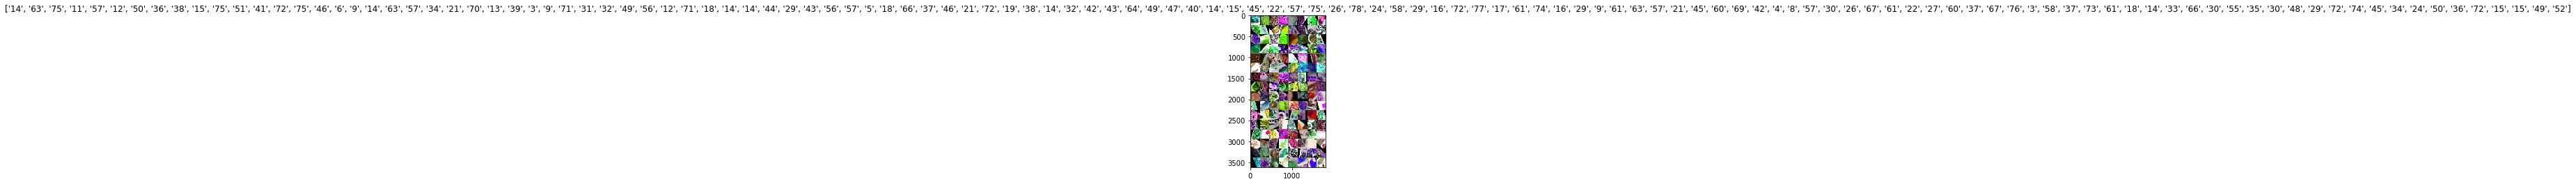

In [82]:
# make class names
class_names = training_dataset.classes

# Show some images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGE_NET_MEAN)
    std = np.array(IMAGE_NET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
 
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(5000, 80)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [0]:
# Function for the validation pass
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [0]:
# Loss function and gradient descent
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [0]:
# Train the classifier

def train_classifier():
  
        epochs = 30
        steps = 0
        print_every = 50

        model.to('cuda')

        for e in range(epochs):
        
            model.train()
    
            running_loss = 0
    
            for images, labels in iter(train_loader):
        
                steps += 1
        
                images, labels = images.to('cuda'), labels.to('cuda')
        
                optimizer.zero_grad()
        
                output = model.forward(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
        
                running_loss += loss.item()
        
                if steps % print_every == 0:
                
                    model.eval()
                
                    # Turn off gradients for validation, saves memory and computations
                    with torch.no_grad():
                        validation_loss, accuracy = validation(model, validate_loader, criterion)
            
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                          "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))
            
                    running_loss = 0
                    model.train()
                    
train_classifier()

In [0]:
torch.save(model.state_dict(), 'vgg16_pretrained_state_dict.pt')

In [0]:
torch.save(model, 'vgg16_pretrained.pt')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
model = torch.load('drive/My Drive/aml/vgg16_pretrained.pt')

In [0]:
# put into evaluation mode
model.eval()

In [0]:
device = torch.device("cuda")
model.to(device)

In [0]:
model.class_to_idx = training_dataset.class_to_idx

In [0]:
from collections import OrderedDict

# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    model = models.vgg16(pretrained=True)
    
    for param in model.parameters():
      param.requires_grad = False
      else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(5000, 80)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

In [0]:
from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image


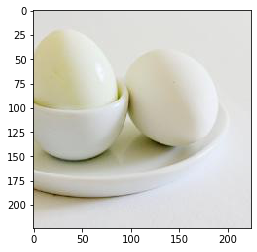

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('test_data/test_set/test_set/test_107.jpg')
imshow(image)

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes
    
probs, classes = predict('test_data/test_set/test_set/test_107.jpg', model)   
print(probs)
print(classes)

[0.999977171421051, 1.1974909284617752e-05, 3.885415935656056e-06, 1.4688255305372877e-06, 1.2751498843499576e-06]
['60', '39', '55', '23', '41']


In [0]:

with open('test_preds.csv', mode='w') as preds:
    preds_writer = csv.writer(preds, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    preds_writer.writerow(['img_name', 'label'])
    preds.close()

In [0]:
pd.read_csv('test_preds.csv').head()

,img_name,label


In [0]:
print(preds.closed)

True


In [0]:

path = 'test_data/test_set/test_set/'

with open('test_preds.csv', mode='w') as preds:
  for image in os.listdir(path):
    probs, classes = predict(path + image, model)
    #print(probs, classes)
    preds_writer = csv.writer(preds, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    preds_writer.writerow([image, classes[0]])